In [35]:
import pandas as pd
import pymongo
import numpy as np
print("hello")

hello


In [2]:
uri = pymongo.MongoClient()
db = uri["hjxh_express_match"]
coll = db["detail"]

In [39]:
N = 0

df = pd.DataFrame(
    list(coll.find(
        {
            "weight_erp": {"$exists": True},
            "weight_trd": {"$exists": True},
        },
        {
            "weight_erp": 1,
            "weight_trd": 1,
            "file_name_erp": 1,
            "file_name_trd": 1,
        },
        limit=N))
)
print(df.shape)

df.sort_index(axis=1, inplace=True)
df

(2025240, 5)


,_id,file_name_erp,file_name_trd,weight_erp,weight_trd
0,YT6051821481165,erp_20211217_销售出库单_李佳欣_1.csv,trd_2021-11_圆通.xlsx,3.62,3.71
1,YT6056690304522,erp_11月旺店通数据.csv,trd_2021-11_圆通.xlsx,4.00,3.72
2,YT6056690316413,erp_11月旺店通数据.csv,trd_2021-11_圆通.xlsx,4.06,3.72
3,YT6056690316515,erp_11月旺店通数据.csv,trd_2021-11_圆通.xlsx,4.06,3.72
4,YT6056690316631,erp_11月旺店通数据.csv,trd_2021-11_圆通.xlsx,4.06,3.72
...,...,...,...,...,...
2025235,462075688836441,erp_11月旺店通数据1.csv,trd_2021-11_漯河韵达.xlsx,2.42,2.50
2025236,462075505302287,erp_11月旺店通数据1.csv,trd_2021-11_漯河韵达.xlsx,2.42,2.53
2025237,3180376115892,erp_11月旺店通数据1.csv,trd_2021-11_漯河韵达.xlsx,1.92,1.92
2025238,3180377527119,erp_11月旺店通数据1.csv,trd_2021-11_漯河韵达.xlsx,2.92,2.93


In [52]:
CONST_DIFF = 0.1
CONST_SMALL = 3  # 非常关键的变量！1-3将指数级影响最终的结果，因为货品的重量分布几乎呈指数分布

### 1. 不考虑trd价格比erp低的，因为这可以减少成本
df["z_less_fail"] = df.weight_erp < df.weight_trd

### 2. 不考虑彼此误差较小的，因为误差难免存在；另外 trd 越小越好，所以应该作分母
df["z_diff_fail"] = abs(df.weight_erp / df.weight_trd - 1) > CONST_DIFF

### 3. 不考虑向上取整相等的，因为大多数情况下不影响最终价格计算
df["z_ceil_fail"] = np.ceil(df.weight_erp) != np.ceil(df.weight_trd)

### 4. 不考虑绝对价格过小的，边际效益较低
df["z_small_fail"] = df.weight_trd > CONST_SMALL

df.query("z_less_fail and z_diff_fail and z_ceil_fail and z_small_fail").sort_values(by="weight_trd", ascending=False)

,_id,file_name_erp,file_name_trd,weight_erp,weight_trd,z_less_fail,z_diff_fail,z_ceil_fail,z_small_fail
1492095,YT6086360113599,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11-沈阳圆通.xlsx,0.920,49.10,True,True,True,True
1503605,YT6085627215864,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11-沈阳圆通.xlsx,1.200,48.05,True,True,True,True
1503481,YT6085625021111,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11-沈阳圆通.xlsx,2.061,46.70,True,True,True,True
1503570,YT6085625010086,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11-沈阳圆通.xlsx,1.200,46.20,True,True,True,True
1492251,YT6086466113569,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11-沈阳圆通.xlsx,3.620,46.10,True,True,True,True
...,...,...,...,...,...,...,...,...,...
985205,432182673735052,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11_常州韵达_无价格表.xlsx,0.520,3.01,True,True,True,True
985207,432181641413750,erp_20211214_销售出库单_李佳欣_2.csv,trd_2021-11_常州韵达_无价格表.xlsx,0.870,3.01,True,True,True,True
1999744,YT6049832537844,erp_10.29-11.1.csv,trd_2021-11-沈阳圆通.xlsx,2.020,3.01,True,True,True,True
27209,3180371664851,erp_11月旺店通数据.csv,trd_2021-11_常州韵达_无价格表.xlsx,2.420,3.01,True,True,True,True


In [10]:
data.weight_qualified.all()

False

<AxesSubplot:>

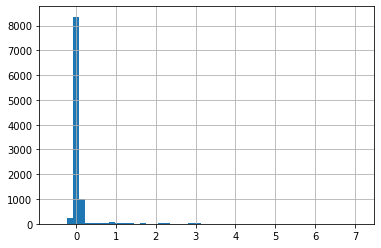

In [11]:
data.weight_diff_pct.hist(bins=50, )